In [13]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

import pandas as pd

from astropy.utils.data import download_file
from astropy.io import fits
import astropy.units as u
from astropy.units import UnitBase, Quantity
from astropy.io.fits.card import Undefined

import grizli
from grizli import utils

from msaexp.spectrum import SpectrumSampler

In [14]:
# Functions for cleaning metadata
def sanitize_value(v):
    """Cleans a dictionary containing astropy quantities, units or undefined value before being saved to a FITS header
    """
    if isinstance(v, UnitBase):
        return v.to_string()
    if isinstance(v, Quantity):
        return f"{v.value} {v.unit.to_string()}"
    if isinstance(v, Undefined):
        return None
    return v

def clean_meta_dict(meta_dict):
    cleaned = {}
    for k, v in meta_dict.items():
        new_key = str(k).upper()  # upper-case the key
        cleaned[new_key] = sanitize_value(v)
    return cleaned

In [15]:
# DJA merged table info
version = "v4.4"
CACHE_DOWNLOADS = True

# Use the Zenodo release
if version == "v4.4":
    URL_PREFIX = "https://zenodo.org/records/15472354/files/"

table_url = f"{URL_PREFIX}/dja_msaexp_emission_lines_{version}.csv.gz"

# Load table
dja_tb = utils.read_catalog(download_file(table_url, cache=CACHE_DOWNLOADS), format='csv')

In [16]:
# Object information 
src_name = 'zf-uds-7329'
obj_id = 55410

# Load all observations
obj_tb = dja_tb[dja_tb['srcid'] == obj_id]
obj_tb

file,srcid,ra,dec,grating,filter,effexptm,nfiles,dataset,msamet,msaid,msacnf,dithn,slitid,root,npix,ndet,wmin,wmax,wmaxsn,sn10,flux10,err10,sn50,flux50,err50,sn90,flux90,err90,xstart,ystart,xsize,ysize,slit_pa,pa_v3,srcypix,profcen,profsig,ctime,version,exptime,contchi2,dof,fullchi2,line_ariii_7138,line_ariii_7138_err,line_ariii_7753,line_ariii_7753_err,line_bra,line_bra_err,line_brb,line_brb_err,line_brd,line_brd_err,line_brg,line_brg_err,line_hb,line_hb_err,line_hd,line_hd_err,line_hei_1083,line_hei_1083_err,line_hei_3889,line_hei_3889_err,line_hei_5877,line_hei_5877_err,line_hei_7065,line_hei_7065_err,line_hei_8446,line_hei_8446_err,line_heii_4687,line_heii_4687_err,line_hg,line_hg_err,line_lya,line_lya_err,line_mgii,line_mgii_err,line_neiii_3867,line_neiii_3867_err,line_neiii_3968,line_neiii_3968_err,line_nev_3346,line_nev_3346_err,line_nevi_3426,line_nevi_3426_err,line_niii_1750,line_niii_1750_err,line_oi_6302,line_oi_6302_err,line_oii,line_oii_7325,line_oii_7325_err,line_oii_err,line_oiii,line_oiii_1663,line_oiii_1663_err,line_oiii_4363,line_oiii_4363_err,line_oiii_4959,line_oiii_4959_err,line_oiii_5007,line_oiii_5007_err,line_oiii_err,line_pa10,line_pa10_err,line_pa8,line_pa8_err,line_pa9,line_pa9_err,line_paa,line_paa_err,line_pab,line_pab_err,line_pad,line_pad_err,line_pag,line_pag_err,line_pfb,line_pfb_err,line_pfd,line_pfd_err,line_pfe,line_pfe_err,line_pfg,line_pfg_err,line_sii,line_sii_err,line_siii_9068,line_siii_9068_err,line_siii_9531,line_siii_9531_err,spl_0,spl_0_err,spl_1,spl_10,spl_10_err,spl_11,spl_11_err,spl_12,spl_12_err,spl_13,spl_13_err,spl_14,spl_14_err,spl_15,spl_15_err,spl_16,spl_16_err,spl_17,spl_17_err,spl_18,spl_18_err,spl_19,spl_19_err,spl_1_err,spl_2,spl_20,spl_20_err,spl_21,spl_21_err,spl_22,spl_22_err,spl_2_err,spl_3,spl_3_err,spl_4,spl_4_err,spl_5,spl_5_err,spl_6,spl_6_err,spl_7,spl_7_err,spl_8,spl_8_err,spl_9,spl_9_err,zline,line_civ_1549,line_civ_1549_err,line_h10,line_h10_err,line_h11,line_h11_err,line_h12,line_h12_err,line_h7,line_h7_err,line_h8,line_h8_err,line_h9,line_h9_err,line_ha,line_ha_err,line_hei_6680,line_hei_6680_err,line_heii_1640,line_heii_1640_err,line_nii_6549,line_nii_6549_err,line_nii_6584,line_nii_6584_err,line_oii_7323,line_oii_7323_err,line_oii_7332,line_oii_7332_err,line_sii_6717,line_sii_6717_err,line_sii_6731,line_sii_6731_err,line_siii_6314,line_siii_6314_err,escale0,escale1,line_ciii_1906,line_ciii_1906_err,line_niv_1487,line_niv_1487_err,line_pah_3p29,line_pah_3p29_err,line_pah_3p40,line_pah_3p40_err,eqw_ariii_7138,eqw_ariii_7753,eqw_bra,eqw_brb,eqw_brd,eqw_brg,eqw_ciii_1906,eqw_civ_1549,eqw_ha_nii,eqw_hb,eqw_hd,eqw_hei_1083,eqw_hei_3889,eqw_hei_5877,eqw_hei_7065,eqw_hei_8446,eqw_heii_1640,eqw_heii_4687,eqw_hg,eqw_lya,eqw_mgii,eqw_neiii_3867,eqw_neiii_3968,eqw_nev_3346,eqw_nevi_3426,eqw_niii_1750,eqw_niv_1487,eqw_oi_6302,eqw_oii,eqw_oii_7325,eqw_oiii,eqw_oiii_1663,eqw_oiii_4363,eqw_oiii_4959,eqw_oiii_5007,eqw_pa10,eqw_pa8,eqw_pa9,eqw_paa,eqw_pab,eqw_pad,eqw_pag,eqw_pfb,eqw_pfd,eqw_pfe,eqw_pfg,eqw_sii,eqw_siii_9068,eqw_siii_9531,line_ha_nii,line_ha_nii_err,eqw_h10,eqw_h11,eqw_h12,eqw_h7,eqw_h8,eqw_h9,eqw_ha,eqw_hei_6680,eqw_nii_6549,eqw_nii_6584,eqw_oii_7323,eqw_oii_7332,eqw_sii_6717,eqw_sii_6731,eqw_siii_6314,sn_line,ztime,line_ci_9850,line_ci_9850_err,line_feii_11128,line_feii_11128_err,line_pii_11886,line_pii_11886_err,line_feii_12570,line_feii_12570_err,eqw_ci_9850,eqw_feii_11128,eqw_pii_11886,eqw_feii_12570,line_feii_16440,line_feii_16440_err,line_feii_16877,line_feii_16877_err,line_brf,line_brf_err,line_feii_17418,line_feii_17418_err,line_bre,line_bre_err,line_feii_18362,line_feii_18362_err,eqw_feii_16440,eqw_feii_16877,eqw_brf,eqw_feii_17418,eqw_bre,eqw_feii_18362,valid,objid,z_best,ztype,z_prism,z_grating,phot_correction,phot_flux_radius,phot_dr,file_phot,id_phot,phot_mag_auto,phot_f090w_tot_1,phot_f090w_etot_1,phot_f115w_tot_1,phot_f115w_etot_1,phot_f150w_tot_1,phot_f150w_etot_1,phot_f200w_tot_1,phot_f200w_etot_1,phot_f277w_tot_1,phot_f277w_etot_1,phot_f

In [17]:
def return_primary_hdu(spec):

    # Make FITS header from clean dict
    hdr_dict = clean_meta_dict(spec.meta)
    hdr = fits.Header(hdr_dict)

    # Convert to empty HDU
    pri_hdu = fits.PrimaryHDU(data=None, header=hdr)

    return pri_hdu

def return_data_hdulist(spec):

    # Add units to spectra
    spec['wave'].unit = spec.meta.get('waveunit')
    spec['flux'].unit = spec.meta.get('fluxunit')
    spec['err'].unit = spec.meta.get('fluxunit')

    # Store data in HDUs
    wave_hdu = fits.ImageHDU(data=spec['wave'].value, name='WAVELENGTH')
    wave_hdu.header['BUNIT'] = str(spec['wave'].unit)

    flux_hdu = fits.ImageHDU(data=spec['flux'].value, name='DATA')
    flux_hdu.header['BUNIT'] = str(spec['flux'].unit)

    err_hdu = fits.ImageHDU(data=spec['wave'].value, name='ERR')
    err_hdu.header['BUNIT'] = str(spec['wave'].unit)

    return wave_hdu, flux_hdu, err_hdu
    

In [18]:
# Extract necessary from DJA table
roots = obj_tb['root'].tolist()
files = obj_tb['file'].tolist()
gratings = obj_tb['grating'].tolist()
filters = obj_tb['filter'].tolist()

out_dir = "/Users/Jonah/PhD/Research/quiescent_galaxies/data_processed/zf-uds-7329/spectra"

# Loop over each spectrum
for (root, file, grating, filter) in zip(roots, files, gratings, filters):

    # Load spectrum
    fits_url = f"https://s3.amazonaws.com/msaexp-nirspec/extractions/{root}/{file}"
    spec = SpectrumSampler(fits_url)

    # Produce FITS HDUs
    pri_hdu = return_primary_hdu(spec)
    wave_hdu, flux_hdu, err_hdu = return_data_hdulist(spec)
    hdulist = fits.HDUList([pri_hdu, wave_hdu, flux_hdu, err_hdu])

    # Save file
    out_name = f"{src_name}_nirspec_{grating.lower()}_{filter.lower()}_1D.fits"
    out_path = os.path.join(out_dir, out_name)
    # hdulist.writeto(out_path, overwrite=True)

In [ ]:
# Conversion functions
def convert_janksy_to_cgs(flux_jy, err_jy, wave_um, return_quantity):

    # Assign units
    wave_um = wave_um * u.um
    flux_jy = flux_jy * u.uJy
    err_jy = err_jy * u.uJy

    # Convert flux to cgs units
    cgs_unit = u.erg/(u.s * u.cm**2 * u.AA) * 1e-20
    flux_cgs = flux_jy.to(cgs_unit, equivalencies=u.spectral_density(wave_um))
    err_cgs = err_jy.to(cgs_unit, equivalencies=u.spectral_density(wave_um))

    if return_quantity:
        return flux_cgs, err_cgs
    else:
        return flux_cgs.value, err_cgs.value

In [115]:
def plot_each_grating_filter_spectrum(wave_um, flux_jy, err_jy, mask, grating, filter):

    # Set all masked data to nan
    wave_um[~mask] = np.nan
    flux_jy[~mask] = np.nan
    err_jy[~mask] = np.nan

    # Add flux in cgs units
    flux_cgs, err_cgs = convert_janksy_to_cgs(flux_jy, err_jy, wave_um, return_quantity=False)
    
    # Create figure
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    combination = '{}-{}'.format(grating, filter)

    # Plot spectral flux in Jys
    ax[0].step(wave_um, flux_jy)
    ax[0].fill_between(wave_um, flux_jy-err_jy, flux_jy+err_jy, color='gray', alpha=0.5)
    # -- prettify
    ax[0].set_xlabel(r'Observed Wavelength / $\mu$m')
    ax[0].set_ylabel(r'Flux / $\mu$Jy')
    ax[0].text(0.03, 0.97, 'ZF-UDS-7329 in {}'.format(combination), transform=ax[0].transAxes, va='top', ha='left')

    # Plot spectral flux in cgs unit
    ax[1].step(wave_um, flux_cgs)
    ax[1].fill_between(wave_um, flux_cgs-err_cgs, flux_cgs+err_cgs, color='gray', alpha=0.5)
    # -- prettify
    ax[1].set_xlabel(r'Observed Wavelength / $\mu$m')
    ax[1].set_ylabel(r'Flux / (erg s cm$^2$ A)')
    ax[1].text(0.03, 0.97, 'ZF-UDS-7329 in {}'.format(combination), transform=ax[1].transAxes, va='top', ha='left')

    # Grating specific axis limits
    if combination == 'G235M-F170LP':
        ax[0].set_ylim(-1, 7.5)
        ax[1].set_ylim(-2.5, 17.5)
    elif combination == 'G140M-F100LP':
        ax[0].set_ylim(-1, 3)
        ax[1].set_ylim(-2.5, 20)
    elif combination == 'G395M-F290LP':
        ax[0].set_ylim(-1, 8)
        ax[1].set_ylim(-2.5, 15)

    plt.tight_layout()

def plot_all_spectra(waves_um, fluxes_jy, errs_jy, masks, gratings, filters):

    # Create figure
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    # Colors for plotting
    colors = ['red', 'blue', 'green']

    for (wave_um, flux_jy, err_jy, mask, grating, filter, color) in zip(waves_um, fluxes_jy, errs_jy, masks, gratings, filters, colors):

        print(filter, grating, wave_um.shape, mask.shape)

        # Set all masked data to nan
        wave_um[~mask] = np.nan
        flux_jy[~mask] = np.nan
        err_jy[~mask] = np.nan

        # Add flux in cgs units
        flux_cgs, err_cgs = convert_janksy_to_cgs(flux_jy, err_jy, wave_um, return_quantity=False)

        # 
        combination = '{}-{}'.format(grating, filter)

        # Plot spectral flux in Jys
        ax[0].step(wave_um, flux_jy, color=color, label=combination)
        ax[0].fill_between(wave_um, flux_jy-err_jy, flux_jy+err_jy, color=color, alpha=0.1)
        # -- prettify
        ax[0].set_xlabel(r'Observed Wavelength / $\mu$m')
        ax[0].set_ylabel(r'Flux / $\mu$Jy')
        ax[0].set_ylim(-1, 8)
        ax[0].legend()

        # Plot spectral flux in cgs unit
        ax[1].step(wave_um, flux_cgs, color=color, label=combination)
        ax[1].fill_between(wave_um, flux_cgs-err_cgs, flux_cgs+err_cgs, color=color, alpha=0.1)
        # -- prettify
        ax[1].set_xlabel(r'Observed Wavelength / $\mu$m')
        ax[1].set_ylabel(r'Flux / (erg s cm$^2$ A)')
        ax[1].set_ylim(-4, 30)
        ax[1].legend()

    plt.tight_layout()

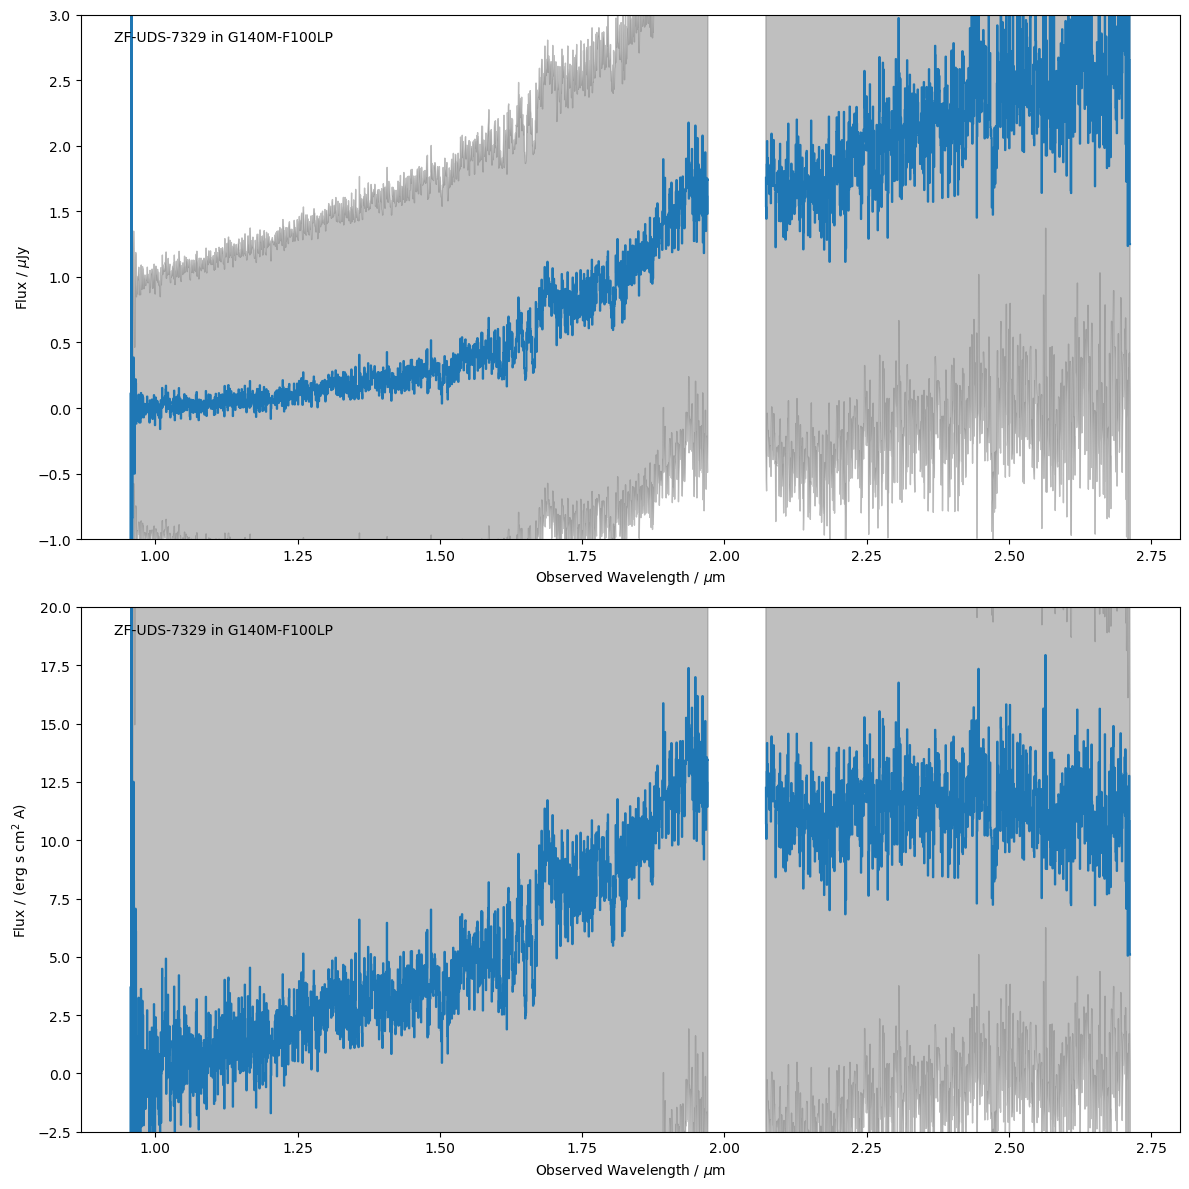

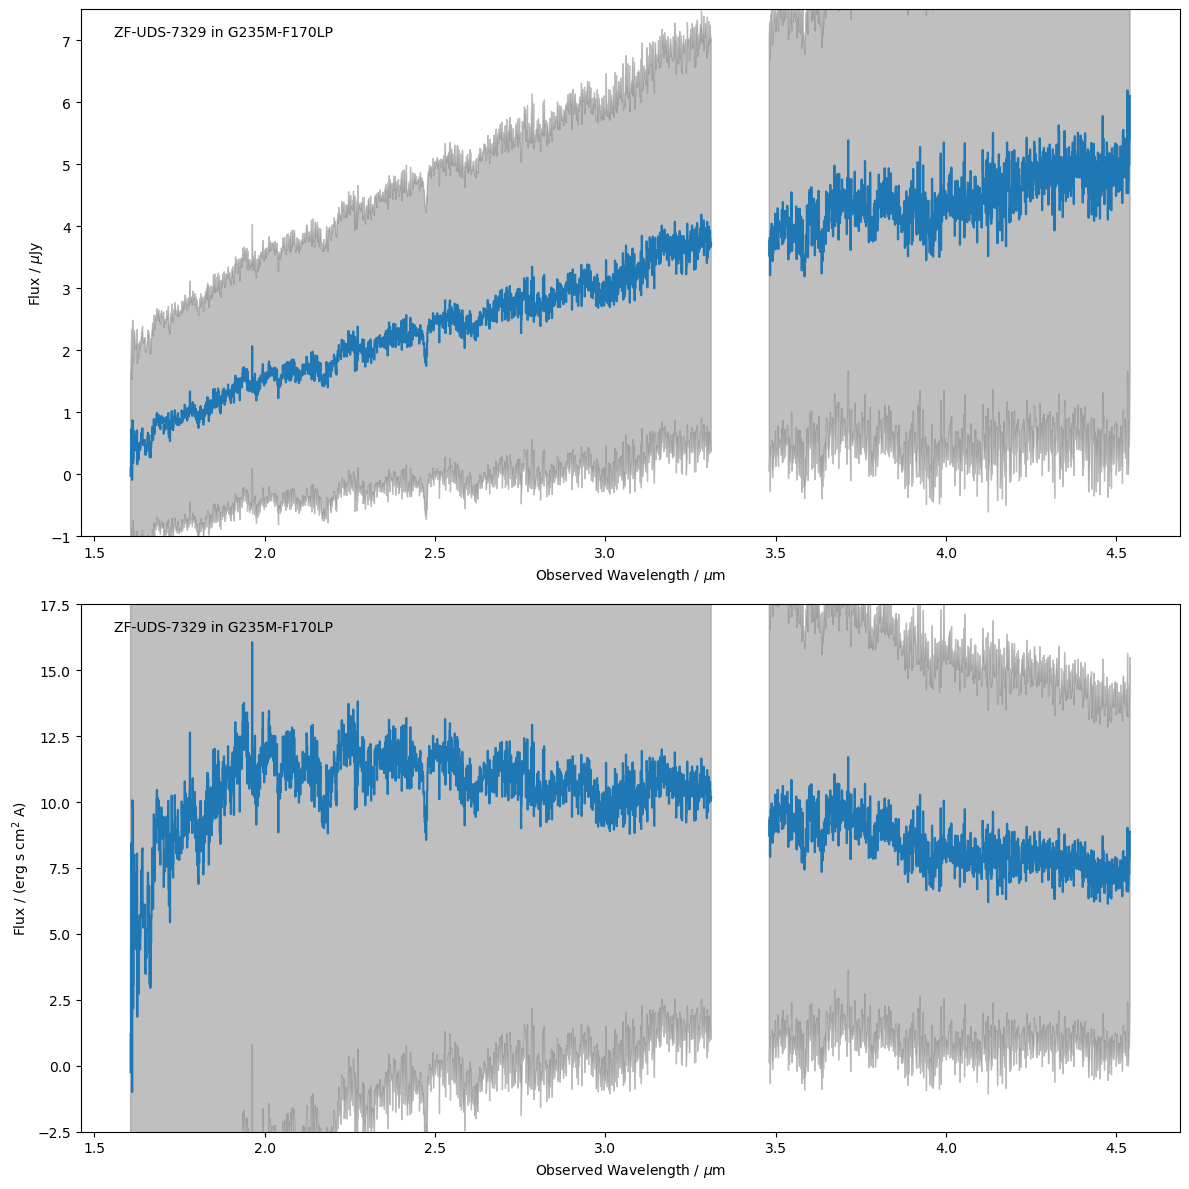

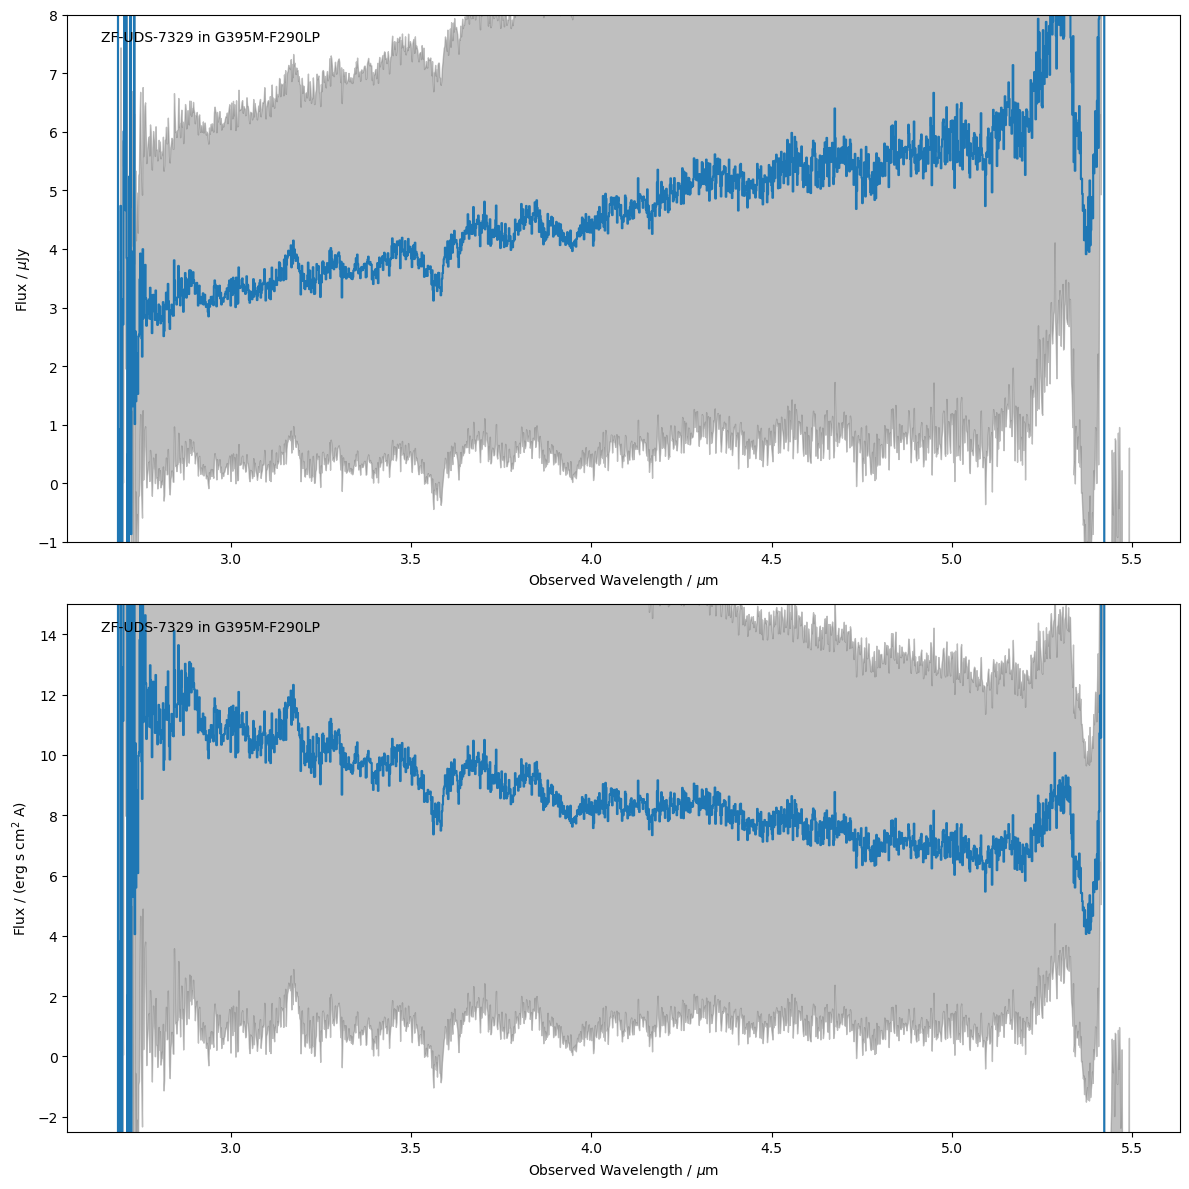

In [116]:
waves_um = []
fluxes_jy = []
errs_jy = []
masks = []

# Inspect DJA spectra
for (root, file, grating, filter) in zip(roots, files, gratings, filters):

    # Load FITS HDUs
    out_name = f"{src_name}_nirspec_{grating.lower()}_{filter.lower()}_1D.fits"
    out_path = os.path.join(out_dir, out_name)
    hdul = fits.open(out_path)

    # Extract data
    wave_hdu = hdul['WAVELENGTH']
    wave_um = wave_hdu.data
    wave_unit = u.Unit(wave_hdu.header['BUNIT'])

    flux_hdu = hdul['DATA']
    flux_jy = flux_hdu.data
    flux_unit = u.Unit(flux_hdu.header['BUNIT'])

    err_hdu = hdul['ERR']
    err_jy = err_hdu.data
    err_unit = u.Unit(err_hdu.header['BUNIT'])

    mask_hdu = hdul['VALID']
    mask = mask_hdu.data.astype(bool)

    # Append data to lists
    waves_um.append(wave_um)
    fluxes_jy.append(flux_jy)
    errs_jy.append(err_jy)
    masks.append(mask)

    plot_each_grating_filter_spectrum(wave_um, flux_jy, err_jy, mask, grating, filter)

F100LP G140M (4667,) (4667,)
F170LP G235M (3685,) (3685,)
F290LP G395M (1661,) (1661,)


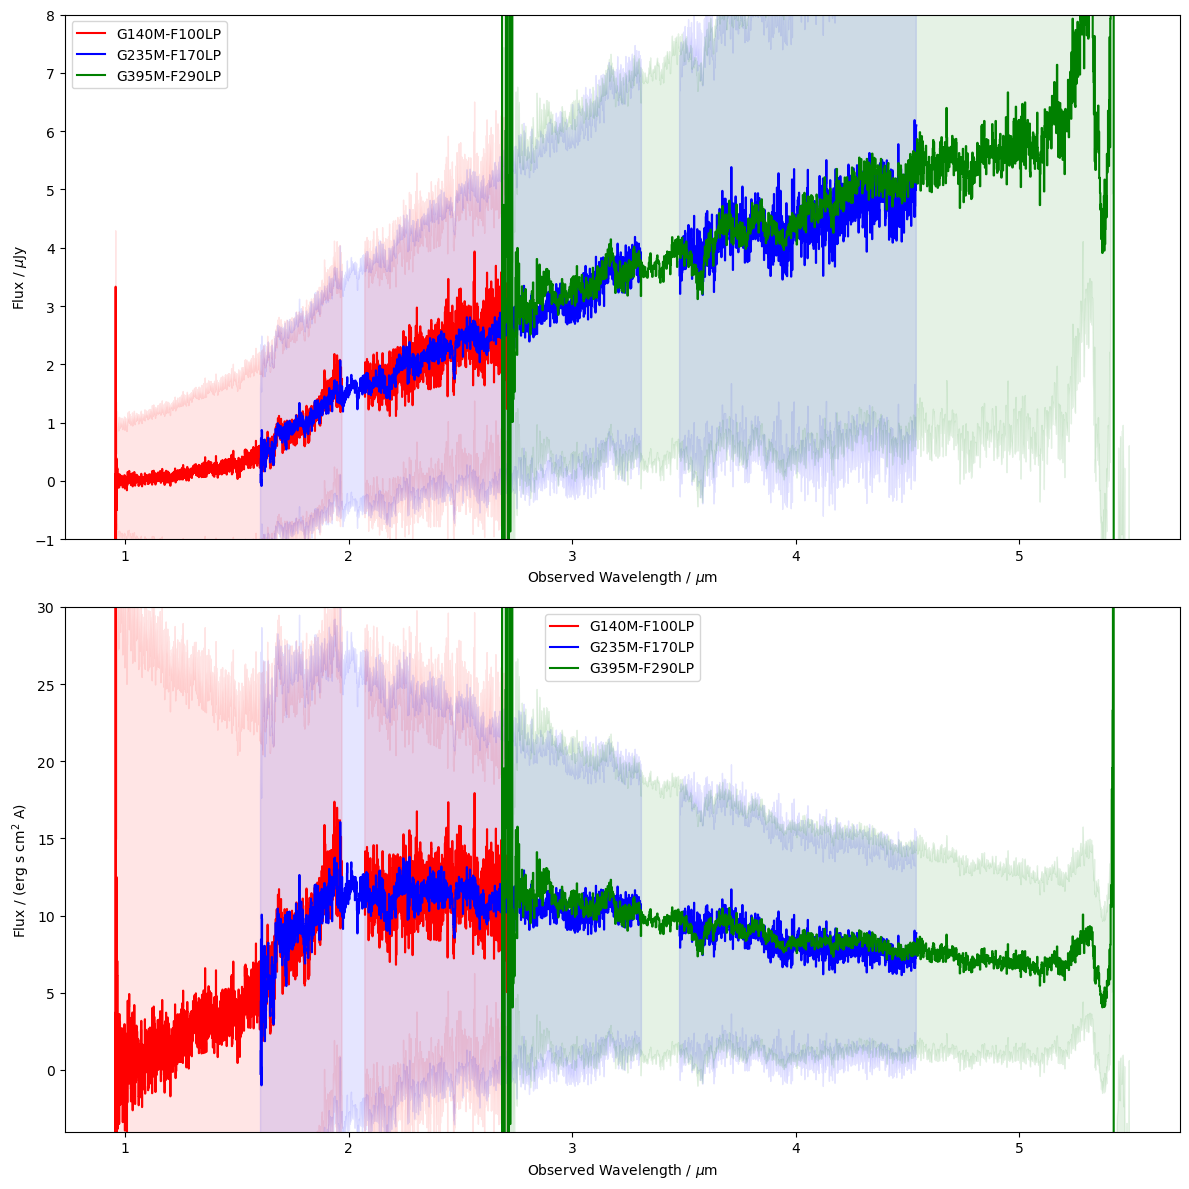

In [117]:
plot_all_spectra(waves_um, fluxes_jy, errs_jy, masks, gratings, filters)